# Preparing

In [3]:
# !nvidia-smi

## Install library

In [4]:
# !pip install --quiet pytorch-lightning==1.2.5
# !pip install --quiet tqdm==4.59.0

## Import libraries

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc, rcParams
import math

import pandas as pd
import numpy as np
import tqdm
print(tqdm.__version__)
from tqdm.notebook import tqdm
import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

4.61.2
1.2.5


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALLETE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALLETE))

rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [7]:
pl.seed_everything(42)

Global seed set to 42


42

# Data

In [8]:
Data_list = []
Column_names = []

### Load watch price

In [9]:
# path = 'Datasets\Price_chart_Game\Rolex\Rolex 126334\price.csv'
path = "Datasets\Price_chart_Tang\Rolex 126334\Combine_all.csv"

watch = pd.read_csv(path, index_col=0)
watch['Price'] = pd.to_numeric(watch['Price'])
watch.index = pd.to_datetime(watch.index, dayfirst=True)
watch = watch.resample('D', convention='s').mean()
watch.fillna(method='ffill', inplace=True)

Column_names.append('watch_price')

watch.head()

,Price
Date,
2017-06-09,9575.0
2017-06-10,9575.0
2017-06-11,9575.0
2017-06-12,9575.0
2017-06-13,9575.0


In [10]:
watch["Prev_30d_Price"] = watch.shift(30)["Price"]
Column_names.append('Prev_30d_Price')
watch = watch[watch['Prev_30d_Price'].notna()]

watch["Price_Change"] = watch.progress_apply(
    lambda row: 0 if np.isnan(row["Prev_30d_Price"]) else row["Price"] - row["Prev_30d_Price"],
    axis = 1
)
Column_names.append('Price_Change')
Data_list.append(watch)
watch.head()

  0%|          | 0/1706 [00:00<?, ?it/s]

,Price,Prev_30d_Price,Price_Change
Date,,,
2017-07-09,6896.0,9575.0,-2679.0
2017-07-10,6896.0,9575.0,-2679.0
2017-07-11,6896.0,9575.0,-2679.0
2017-07-12,6896.0,9575.0,-2679.0
2017-07-13,6896.0,9575.0,-2679.0


### Load gold price

In [11]:
gold = pd.read_csv("Datasets\Related_data\Gold_price.csv", index_col=0)
gold['Value'] = gold['Value'].str.replace(',','')
gold['Value'] = pd.to_numeric(gold['Value'])
gold.index = pd.to_datetime(gold.index, dayfirst=True)
gold = gold.resample('D', convention='s').mean()
gold.fillna(method='ffill', inplace=True)
print(gold.shape)

Column_names.append('gold_price')

gold.head()

(1895, 1)


,Value
Date,
2017-01-02,1145.9
2017-01-03,1151.0
2017-01-04,1164.3
2017-01-05,1176.7
2017-01-06,1175.9


In [12]:
gold["Prev_gold_price"] = gold.shift(30)["Value"]
Column_names.append('Prev_gold_price')
gold = gold[gold['Prev_gold_price'].notna()]

gold["Gold_price_Change"] = gold.progress_apply(
    lambda row: 0 if np.isnan(row["Prev_gold_price"]) else row["Value"] - row["Prev_gold_price"],
    axis = 1
)
Column_names.append('Gold_price_Change')
Data_list.append(gold)
gold.head()

  0%|          | 0/1865 [00:00<?, ?it/s]

,Value,Prev_gold_price,Gold_price_Change
Date,,,
2017-02-01,1203.7,1145.9,57.8
2017-02-02,1222.0,1151.0,71.0
2017-02-03,1215.2,1164.3,50.9
2017-02-04,1215.2,1176.7,38.5
2017-02-05,1215.2,1175.9,39.3


### Load Inflation rate

In [13]:
IR = pd.read_csv("Datasets\Related_data\Inflation_rate.csv", index_col=0)
IR['Value'] = IR['Value'].str.replace(',','')
for _, item in IR.iterrows():
    if item[0] == '.': item[0] = np.nan
IR['Value'] = pd.to_numeric(IR['Value'])
IR.index = pd.to_datetime(IR.index, dayfirst=True)
IR = IR.resample('D', convention='s').mean()
IR.fillna(method='ffill', inplace=True)
print(IR.shape)
IR.head()

(1825, 1)


,Value
DATE,
2017-03-13,2.16
2017-03-14,2.10
2017-03-15,2.18
2017-03-16,2.17
2017-03-17,2.13


### Load stock data

In [14]:
GLG = pd.read_csv("Datasets\Related_data\S&P Global Luxury Goods.csv", index_col=0)
for col in GLG.columns:
    GLG[col] = GLG[col].str.replace(',','')
    GLG[col] = GLG[col].str.replace('%','')
    GLG[col] = pd.to_numeric(GLG[col])
    Column_names.append('GLG_'+col)
GLG.index = pd.to_datetime(GLG.index, dayfirst=True)
GLG = GLG.resample('D', convention='s').mean()
GLG.fillna(method='ffill', inplace=True)
print(GLG.shape)
Data_list.append(GLG)
GLG.head()

(1795, 5)


,Price,Open,High,Low,Change %
Date,,,,,
2017-04-11,2138.81,2138.81,2138.81,2138.81,0.21
2017-04-12,2140.47,2140.47,2140.47,2140.47,0.08
2017-04-13,2137.98,2137.98,2137.98,2137.98,-0.12
2017-04-14,2137.31,2137.31,2137.31,2137.31,-0.03
2017-04-15,2137.31,2137.31,2137.31,2137.31,-0.03


## Concat all

In [15]:
df = pd.concat(Data_list, axis=1, join='inner')
df.columns = Column_names
print(df.shape)
df.head()

(1706, 11)


,watch_price,Prev_30d_Price,Price_Change,gold_price,Prev_gold_price,Gold_price_Change,GLG_Price,GLG_Open,GLG_High,GLG_Low,GLG_Change %
Date,,,,,,,,,,,
2017-07-09,6896.0,9575.0,-2679.0,1215.7,1266.6,-50.9,2276.99,2276.99,2276.99,2276.99,0.10
2017-07-10,6896.0,9575.0,-2679.0,1211.9,1266.6,-54.7,2281.48,2281.48,2281.48,2281.48,0.20
2017-07-11,6896.0,9575.0,-2679.0,1211.1,1266.6,-55.5,2276.08,2276.08,2276.08,2276.08,-0.24
2017-07-12,6896.0,9575.0,-2679.0,1218.8,1266.4,-47.6,2298.02,2298.02,2298.02,2298.02,0.96
2017-07-13,6896.0,9575.0,-2679.0,1218.9,1262.0,-43.1,2301.92,2301.92,2301.92,2301.92,0.17


In [16]:
df['Date'] = df.index
df.head()

,watch_price,Prev_30d_Price,Price_Change,gold_price,Prev_gold_price,Gold_price_Change,GLG_Price,GLG_Open,GLG_High,GLG_Low,GLG_Change %,Date
Date,,,,,,,,,,,,
2017-07-09,6896.0,9575.0,-2679.0,1215.7,1266.6,-50.9,2276.99,2276.99,2276.99,2276.99,0.10,2017-07-09
2017-07-10,6896.0,9575.0,-2679.0,1211.9,1266.6,-54.7,2281.48,2281.48,2281.48,2281.48,0.20,2017-07-10
2017-07-11,6896.0,9575.0,-2679.0,1211.1,1266.6,-55.5,2276.08,2276.08,2276.08,2276.08,-0.24,2017-07-11
2017-07-12,6896.0,9575.0,-2679.0,1218.8,1266.4,-47.6,2298.02,2298.02,2298.02,2298.02,0.96,2017-07-12
2017-07-13,6896.0,9575.0,-2679.0,1218.9,1262.0,-43.1,2301.92,2301.92,2301.92,2301.92,0.17,2017-07-13


## Create feature df

In [17]:
rows = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_data = dict(
        # day_of_week = row.Date.dayofweek,
        # day_of_month = row.Date.day,
        week_of_year = row.Date.week,
        month = row.Date.month,
        watch_price = row.watch_price,
        price_change = row.Price_Change,
        # gold_price_change = row.Gold_price_Change,
        # GLG_price = row.GLG_Price,
        # GLG_open = row.GLG_Open,
        # GLG_high = row.GLG_High,
        # GLG_low = row.GLG_Low,
        # GLG_change = row['GLG_Change %']
        
    )
    rows.append(row_data)

features_df = pd.DataFrame(rows)

  0%|          | 0/1706 [00:00<?, ?it/s]

In [18]:
print(features_df.shape)
features_df.head()

(1706, 4)


,week_of_year,month,watch_price,price_change
0,27,7,6896.0,-2679.0
1,28,7,6896.0,-2679.0
2,28,7,6896.0,-2679.0
3,28,7,6896.0,-2679.0
4,28,7,6896.0,-2679.0


## Set TRAIN_RATIO

In [19]:
TRAIN_RATIO = 0.8

train_size = int(len(features_df) * TRAIN_RATIO)
print(train_size)

1364


In [20]:
train_df, test_df = features_df[:train_size], features_df[train_size:]
print(train_df.shape, test_df.shape)

(1364, 4) (342, 4)


In [21]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(features_df)

In [22]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

In [23]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns
)

In [24]:
test_df.head()

,week_of_year,month,watch_price,price_change
1364,-0.538462,-0.454545,0.420035,0.107860
1365,-0.538462,-0.454545,0.420738,0.102843
1366,-0.500000,-0.454545,0.415114,0.092809
1367,-0.500000,-0.454545,0.414646,0.091973
1368,-0.500000,-0.454545,0.415114,0.092809


In [25]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, days_pred):

    sequences = []
    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_length - days_pred)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length + days_pred
        label = input_data.iloc[label_position][target_column]
        
        sequences.append((sequence, label))

    return sequences

## Set SEQUENCE_LENGTH and Created sequences

In [26]:
SEQUENCE_LENGTH = 30
DAYS_PREDICTION = 30

train_sequences = create_sequences(train_df, "watch_price", SEQUENCE_LENGTH, DAYS_PREDICTION)
test_sequences = create_sequences(test_df, "watch_price", SEQUENCE_LENGTH, DAYS_PREDICTION)

  0%|          | 0/1304 [00:00<?, ?it/s]

  0%|          | 0/282 [00:00<?, ?it/s]

In [27]:
print(f"Sequence shape: {train_sequences[0][0].shape}")
print(f"Train length: {len(train_sequences)}")
print(f"Test length: {len(test_sequences)}")
print(f"Test length: {train_sequences[0][1]}")
train_sequences[0][0].head()

Sequence shape: (30, 4)
Train length: 1304
Test length: 282
Test length: -0.8064440538957234


,week_of_year,month,watch_price,price_change
0,0.000000,0.090909,-0.806444,-1.0
1,0.038462,0.090909,-0.806444,-1.0
2,0.038462,0.090909,-0.806444,-1.0
3,0.038462,0.090909,-0.806444,-1.0
4,0.038462,0.090909,-0.806444,-1.0


# Classes create

## Set device

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("configured device:", device)

configured device: cuda


## TS_Dataset (Time series)

In [29]:
class TS_Dataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device),
            label = torch.tensor(label).float().to(device)
        )

## Price Data Module

In [30]:
class PriceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def prepare_data(self):
        self._has_prepared_data = True

    def setup(self):
        self.train_dataset = TS_Dataset(self.train_sequences)
        self.test_dataset = TS_Dataset(self.test_sequences)
        self.prepare_data()
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=4,
            shuffle=False
        )
        
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False
        )

## Define BATCH_SIZE and N_EPOCHS

In [31]:
N_EPOCHS = 100
BATCH_SIZE = 64

data_module = PriceDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

In [32]:
train_dataset = TS_Dataset(train_sequences)

In [33]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break

torch.Size([30, 4])
torch.Size([])
tensor(-0.8064, device='cuda:0')


## Price Prediction Model

In [34]:
class PricePredictionModel(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size =n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

## Price Predictor

In [35]:
class PricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model = PricePredictionModel(n_features).to(device)
        self.criterion = nn.MSELoss().to(device)

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss    

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.Adagrad(self.parameters(), lr=1e-3)

In [36]:
model = PricePredictor(n_features=train_df.shape[1])

In [37]:
for item in data_module.train_dataloader():
    print(item["sequence"].shape)
    print(item["label"].shape)
    break

torch.Size([64, 30, 4])
torch.Size([64])


# Start Tensorboard

In [38]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Reusing TensorBoard on port 6006 (pid 18628), started 1 day, 22:35:47 ago. (Use '!kill 18628' to kill it.)

## checkpoint_callback setup

In [39]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    # verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="watch-price")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


## Fit

In [40]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 200 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
200 K     Trainable params
0         Non-trainable params
200 K     Total params
0.803     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 92/92 [00:00<00:00, 109.79it/s, loss=0.00897, v_num=0, val_loss=0.00958, train_loss=0.000391]


1

# Evaluation

## Load trained model

In [ ]:
trained_model = PricePredictor.load_from_checkpoint(
    "checkpoints/best-checkpoint.ckpt",
    n_features=train_df.shape[1]
)

In [ ]:
trained_model.freeze()

## Predictions

In [ ]:
test_dataset = TS_Dataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

  0%|          | 0/282 [00:00<?, ?it/s]

In [ ]:
len(predictions), len(test_df)-SEQUENCE_LENGTH

(282, 312)

## Descale

In [ ]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [ ]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
print(scaler.min_[-1], scaler.scale_[-1])

predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)
print(predictions[:5])
print("Predictions: ", predictions_descaled[:5])
print("Labels: ", labels_descaled[:5])

0.11998327759197314 0.0004180602006688963
[0.4201413094997406, 0.4198431074619293, 0.4200008809566498, 0.42074620723724365, 0.4220884144306183]
Predictions:  [717.97801232 717.26471305 717.64210725 719.42492771 722.63548732]
Labels:  [914.46501589 912.22303486 910.54137087 905.49680662 917.82805872]


## Plot graph

In [ ]:
# train_data = watch[:train_size]
test_data = watch[train_size:]
print(test_data.shape)
print(test_df.shape)

(342, 3)
(342, 4)


In [ ]:
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]
print(test_sequences_data.shape)

(312, 3)


In [ ]:
test_sequences_data.head()

,Price,Prev_30d_Price,Price_Change
Date,,,
2021-05-03,12115.0,12130.0,-15.0
2021-05-04,12135.0,12133.0,2.0
2021-05-05,12162.0,12109.0,53.0
2021-05-06,12193.0,12107.0,86.0
2021-05-07,12205.0,12109.0,96.0


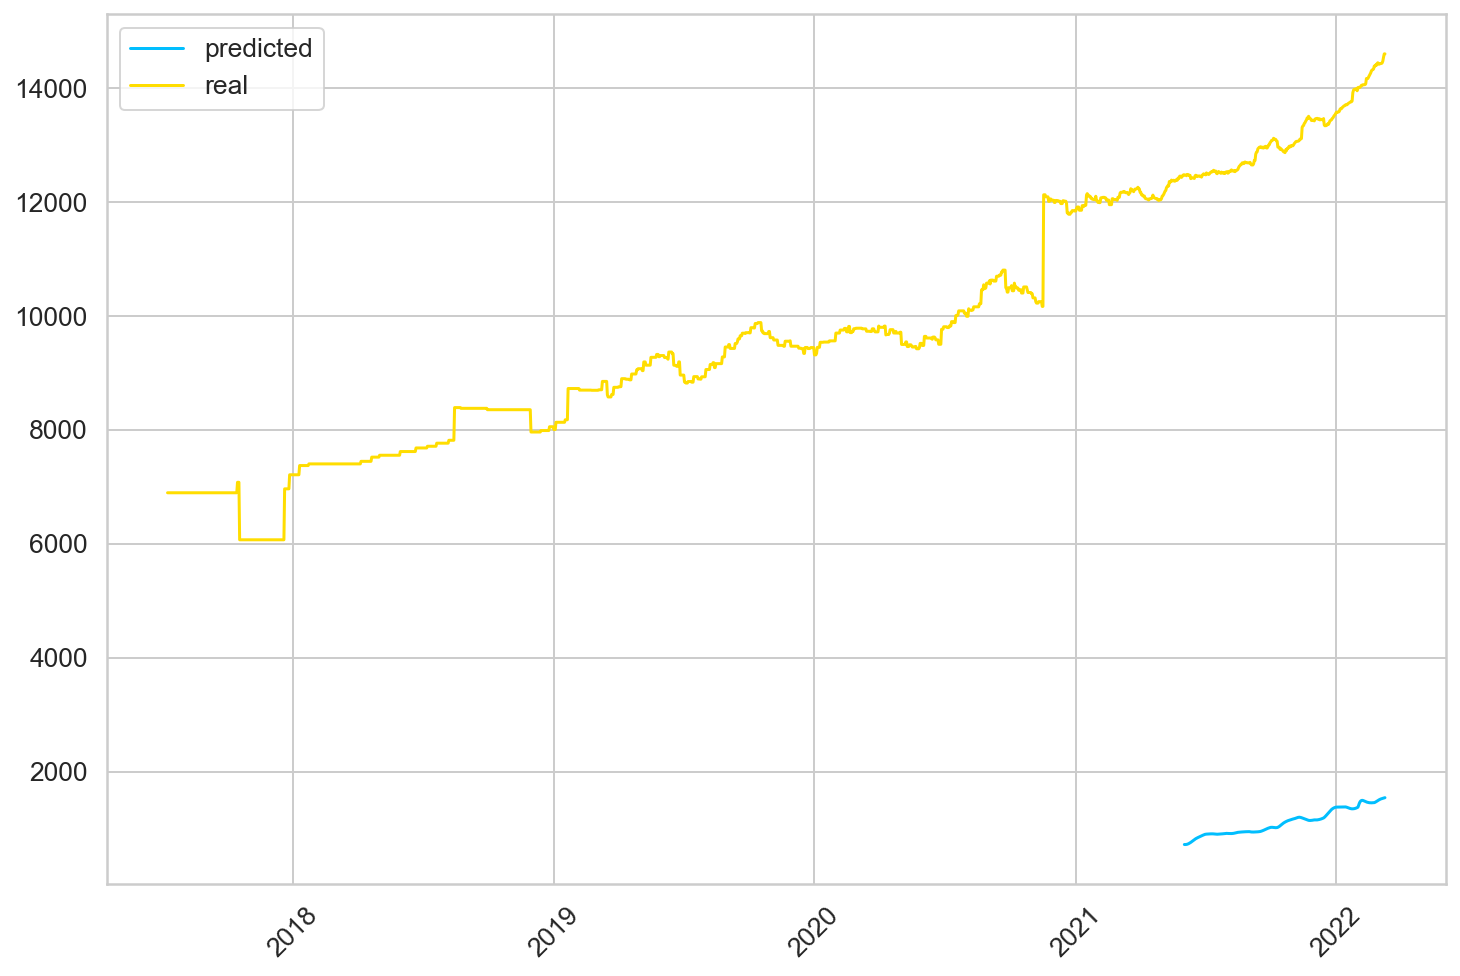

In [ ]:
test_dates = matplotlib.dates.date2num(test_sequences_data.index.tolist())
all_dates = matplotlib.dates.date2num(watch.index.tolist())
plt.plot_date(test_dates[DAYS_PREDICTION:], predictions_descaled, '-', label='predicted')
# plt.plot_date(test_dates, labels_descaled, '-', label='real')
plt.plot_date(all_dates, watch.Price.tolist(), '-', label='real')
i = 150
# plt.plot_date([test_dates[i], test_dates[DAYS_PREDICTION+i]], [labels_descaled[i-DAYS_PREDICTION], predictions_descaled[i]], '-', label='PREDICTION')

plt.xticks(rotation=45)
plt.legend()
plt.show()

# Evalution function

In [ ]:
# class prediction:
#     def __init__(self, model_path, n_features):
#         self.trained_model = PricePredictor.load_from_checkpoint(
#             model_path,
#             n_features=n_features
#         )
#         self.trained_model.freeze()

#     def get_result(self, sequence, days):
#         _, predictions = trained_model(sequence.unsqueeze(dim=0))
        


In [ ]:
import numpy as np
pred = np.array(predictions_descaled)
real = np.array(features_df.price.tolist())
err = abs(pred-real)

NameError: name 'predictions_descaled' is not defined